# Sentiment Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


### Load & explore data

In [2]:
data = pd.read_csv('emotions.csv')
data

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness
...,...,...
19995,i was i might be buying stuff from there but i...,joy
19996,i like sonam deepika and genelia who i feel ar...,joy
19997,i feel pathetic that i can hardly go a whole d...,sadness
19998,id have spent more time with her on reading i ...,sadness


In [3]:
# Find the longest row and count the number of chars/words. Useful in order to set an
# appropriate max_words for pad_sequences later on
longest_row_index = data['text'].str.len().idxmax()
longest_row = data['text'].loc[longest_row_index]

longest_row_char_count = len(longest_row)
longest_row_word_count = len(longest_row.split(' '))

print(
    f'longest row\n',
    f'characters: {longest_row_char_count}\n',
    f'words: {longest_row_word_count}'
)

longest row
 characters: 300
 words: 62


In [4]:
# Looks like we sadly don't have enough data to balance the dataset
print(data['label'].value_counts())

label
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64


### Preprocessing

In [5]:
max_words_to_use = 1000

# Tokenize the text data (convert them into "sequences")
tokenizer = Tokenizer(num_words=max_words_to_use) # Consider only using the top 1000 words, as those 
tokenizer.fit_on_texts(data['text'])
tokenized_data = tokenizer.texts_to_sequences(data['text'])

# printing using loop for easier viewing (i fucking hate python sometimes man. Someone ought to be burned at the stake for their sins)
for i in range(5):
    print(f'seq {i}: {tokenized_data[i]}')

seq 0: [1, 2, 14, 513, 161, 115, 76, 274, 277, 3, 68, 178]
seq 1: [73, 322, 12, 99, 131, 6, 275, 29, 5, 24, 10, 3, 5, 10, 714, 119, 14, 84, 3, 152, 495]
seq 2: [1, 116, 2, 12, 21, 762, 8, 35, 5, 964, 9, 87, 4, 782, 5, 367, 57, 27, 50]
seq 3: [1, 2, 665, 6, 203, 187]
seq 4: [1, 323, 4, 300, 8, 6, 7, 13, 763, 18, 4, 27, 614, 34, 111, 162, 37, 29, 22, 11, 6, 242]


In [12]:
max_sequence_length = 100

# Pad the sequences to make them of uniform length
tokenized_padded_data = pad_sequences(tokenized_data, maxlen=max_sequence_length)
print(f'seq 0:\n{tokenized_padded_data[0]}')

seq 0:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2
  14 513 161 115  76 274 277   3  68 178]


In [22]:
# One-hot encode the labels
label_binarizer = LabelBinarizer()
onehot_encoded_labels = label_binarizer.fit_transform(data['label'])

for i in range(5):
    print(f'seq {i}: {onehot_encoded_labels[i]}')

seq 0: [1 0 0 0 0 0]
seq 1: [1 0 0 0 0 0]
seq 2: [0 0 0 0 1 0]
seq 3: [1 0 0 0 0 0]
seq 4: [0 0 0 0 1 0]


In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    tokenized_padded_data,
    onehot_encoded_labels,
    test_size=0.2
)

print(
    f'x_train shape: {np.shape(x_train)}\n'
    f'y_train shape: {np.shape(y_train)}\n'
    f'x_test shape: {np.shape(x_test)}\n'
    f'y_test shape: {np.shape(y_test)}'
)

x_train shape: (16000, 100)
y_train shape: (16000, 6)
x_test shape: (4000, 100)
y_test shape: (4000, 6)


### Create & train model

In [25]:
# Manually added to array for easy viewing of the architectures

models = {
    'RNN':
    Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32
        ),
        SimpleRNN(units=32, activation='tanh'),
        Dense(units=6, activation='softmax')
    ]),
    
    'LSTM':
    Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32
        ),
        LSTM(units=32, activation='tanh'),
        Dense(6, activation='softmax')
    ])
}

In [21]:
histories = []

for _, model in models.items():
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Using a patience and start_from_epoch of 10 as the model is still all over the place before that
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=10)
    histories.append(model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=1))

Epoch 1/100


400/400 [==============================] - 14s 29ms/step - loss: 1.5606 - accuracy: 0.3734 - val_loss: 1.5074 - val_accuracy: 0.3928
Epoch 2/100
400/400 [==============================] - 12s 29ms/step - loss: 1.1623 - accuracy: 0.5777 - val_loss: 1.0026 - val_accuracy: 0.6522
Epoch 3/100
400/400 [==============================] - 11s 28ms/step - loss: 0.7602 - accuracy: 0.7494 - val_loss: 0.7310 - val_accuracy: 0.7544
Epoch 4/100
400/400 [==============================] - 12s 30ms/step - loss: 0.5888 - accuracy: 0.8146 - val_loss: 0.6580 - val_accuracy: 0.7953
Epoch 5/100
400/400 [==============================] - 11s 28ms/step - loss: 0.4594 - accuracy: 0.8581 - val_loss: 0.5891 - val_accuracy: 0.8216
Epoch 6/100
400/400 [==============================] - 12s 30ms/step - loss: 0.4000 - accuracy: 0.8762 - val_loss: 0.5778 - val_accuracy: 0.8294
Epoch 7/100
400/400 [==============================] - 15s 36ms/step - loss: 0.3507 - accuracy: 0.8912 - val_loss: 0.6130 - val_accuracy: 0.81

### Evaluate performance

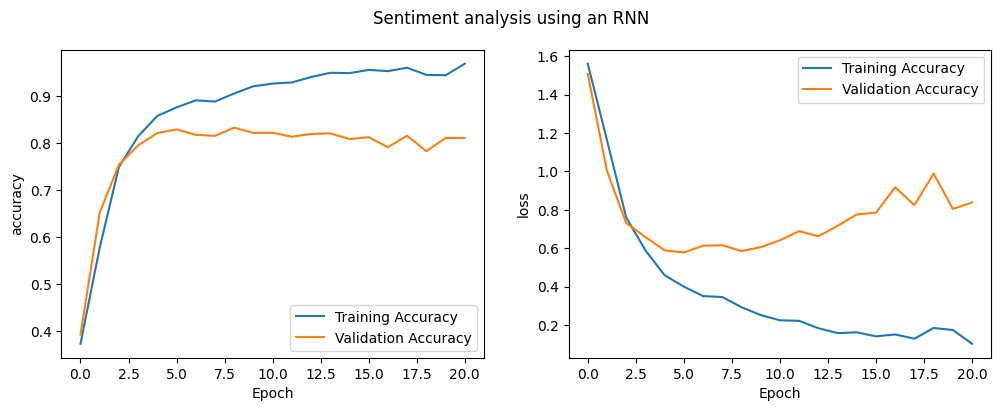

Accuracy: 83.0%
Loss: 0.61


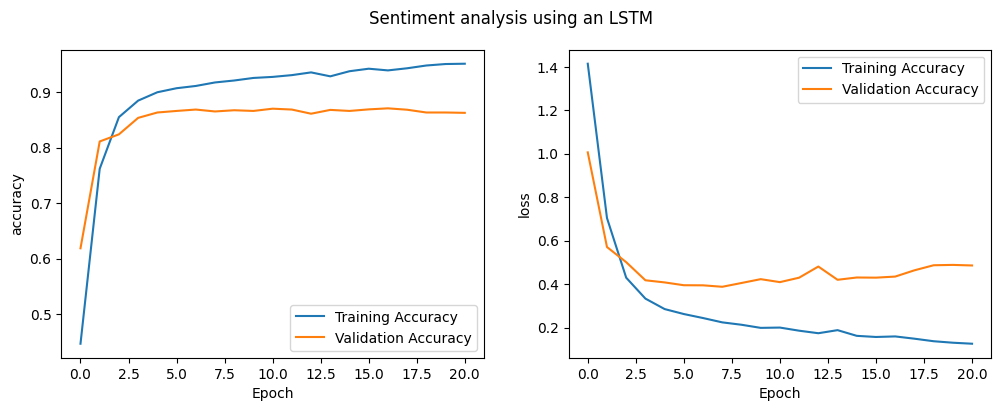

Accuracy: 87.0%
Loss: 0.39


In [22]:
# Pretty straightforward code once you read it twice
for (name, model), history in zip(models.items(), histories):
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    plt.figure(figsize=(12, 4))
    
    for subplot, metric in enumerate(['accuracy', 'loss'], 1):
        plt.subplot(1, 2, subplot)
        plt.plot(history.history[metric], label='Training Accuracy')
        plt.plot(history.history[f'val_{metric}'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.suptitle(f'Sentiment analysis using an {name}')
    plt.show()

    print(
        f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
        f'Loss: {round(test_loss, 2)}'    
    )

### Hyperparameter usage motivation

- #### Motivera din modellarkitektur och val av relevanta hyperparametrar.<br>
    
    I initially settled on a "vanilla" RNN, but later decided on using an LSTM instead, given the task at hand. I non the less included both models for comparison purposes.
    
    The two models are both (obviously) based on the recurrent neural network architecture, with the only difference being that one is an LSTM. All other hyperparameters identical.

    We start off by running the data through an embedding layer, which converts the words/tokens into dense vectors of fixed size. This helps to capture semantic relationships as words with similar meanings tend to have similar vector representations. This is essentially a must for RNNs performing tasks such as semantic analysis. After embedding the data, we feed it into our RNN with 32 units and an activation function of tanh (more on why later) and finally out to our output dense layer. That's it!<br>
    It's an extremely simple yet surprisingly effective architecture.  

    Now for the hyperparameter choices, which I'll be elaborating and explaning one by one.
      
  - SimpleRNN/LSTM units
    - Experimented around with 8, 16, 32.. etc. until settling on 32, which gave me the best results. Essentially a bunch of trial and error.
      
  - SimpleRNN/LSTM activation
    - Used tanh as it was generally the most fitting for RNNs. tanh provides a number of benefits when it comes to RNNs given it's bounded to -1 - 1, making the network less likely to suffer from things like vanishing gradient problems.
  
  - Dense units/activation
    - 6 output neurons to account for our 6 labels, with the activation function being softmax as that helps in generating probabilities as output for classification.



- #### Vilka aktiveringsfunktioner har du använt? Varför?
  - Already stated above

- #### Vilken loss funktion har du använt? Varför?
  - Being that we're training a classifier, categorical_crossentropy seemed most appropriate. This because it's effective for training models to make accurate multi class predictions.

- #### Har du använt någon databehandling? Varför?
  - yes, plenty. In order for to feed textual data into the RNNs, i firstly needed to tokenize it. Tokenizing text simply converts it into a "sequence" of numbers which correspond to different words (delimited by a space). This is a must as neural networks work based off of numbers and not letters. The second order of business was to pad the sequences of numbers. Padding (in this case) involves ensuring that the sequences are of equal length, regardless of the underlying sentence length (which can obviously vary quite a bit). This is done by declaring a "window" of tokenized words which is than filled by zeros in order to "pad" the length up to a fixed size, in this case 100 words.
  Lastly, i than one-hot encoded the labels in order for them to work with the networks categorical_crossentropy loss function.<br><br>Now, i could've also remove the stop words and performed lemmatization, but i simply didn't see a need. The amount of data we have is minuscule. It simply wouldn't benefit it. I also doubt model performance would change much. If anything, it may go down as the data would contain slightly less contextual information.
  

- #### Har du använt någon regulariseringsteknik? Motivera.
  - Only early stopping. I was initially quite sure that I'd need to spend a good amount of time tinkering with various regularization techniques, but apparently not. The networks performed surprisingly well, with the only downside being that they started grossly overfitting at semi random epoch intervals. After having solved that issue, i opted for simplicity rather than pushing the bounds of accuracy.

- #### Hur har modellen utvärderats?
  - By looking at the validation/test data accuracy and loss

- #### Är prestandan bra? Varför/ varför inte?
  - Surprisingly.<br>
  Wasn't expecting the RNN to whip out an >80% accuracy given such a simple architecture. Likewise for the LSTM. Just goes to show how good RNNs are at finding meaning in sequences of data. The LSTM does a bit better than the vanilla RNN alone, to no ones surprise. This is due to the LSTM performing better on longer sentences given its ability to "recall" context from what it has "read" from in "the past". Much like us humans.

- #### Vad hade du kunnat göra för att förbättra den ytterligare?
  - I'll paraphrase the same thing i said in lab 1, as it very much still applies here.<br><br>There are a myriad of possible techniques which i didn't explore. Everything from simply continuing to mess around with the architecture, to performing a comprehensive gridsearch of the parameter space in order to obtain the best model. The addition of stop word removal, lemmatization or even just a few more dense layers may also have given the model a slight advantage. But that would've also made the train time far longer. All of this is to say that in this field of computer science, you can always tweak things. One must call it quits at some point! >80% accuracy is spectacular in my books, especially when considering the fact that you'd have gotten roughly 16% had the model simply guessed at random.